# Tutorial: HDF5 Stokes data
This tutorial will cover how to read beamformed Stokes I data in HDF5 format.

Again, let's load the python libraries that we will use.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Next, we open the HDF5 header of the first beam of the first sub-array pointing, and investigate the `STOKES_0` sub-group.

In [12]:
os.chdir("../../data/L631533")
h5 = h5py.File("L631533_SAP000_B000_S0_P000_bf.h5", "r")

In [13]:
group = h5["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_0"]
keys = sorted(["%s"%item for item in sorted(list(group.attrs))])
for key in keys:
    print(key + " = " + str(group.attrs[key]))

DATATYPE = float
GROUPTYPE = bfData
NOF_CHANNELS = [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16]
NOF_SAMPLES = 57216
NOF_SUBBANDS = 128
STOKES_COMPONENT = I


As you can see, the data in this group is Stokes I, represented as floating point values, with 128 subbands, each channelized to 16 channels per subband. The total number of samples (read spectra) is 57216.

Next, we'll read the actual Stokes I filterbank, as well as the header information about the two axes and plot the data.

Note that we are converting the filterbank into decibels, using $y_\mathrm{dB} = 10 \log_{10}(y)$, to deal with the large range of values in the file.

In [14]:
stokes = h5["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_0"]
data = 10.0 * np.log10(stokes)
freq = h5["/SUB_ARRAY_POINTING_000/BEAM_000/COORDINATES/COORDINATE_1"].attrs["AXIS_VALUES_WORLD"] * 1e-6
tsamp = h5["/SUB_ARRAY_POINTING_000/BEAM_000/COORDINATES/COORDINATE_0"].attrs["INCREMENT"]
t = tsamp * np.arange(stokes.shape[0])

In [15]:
vmin = np.median(data) - 2.0 * np.std(data)
vmax = np.median(data) + 6.0 * np.std(data)

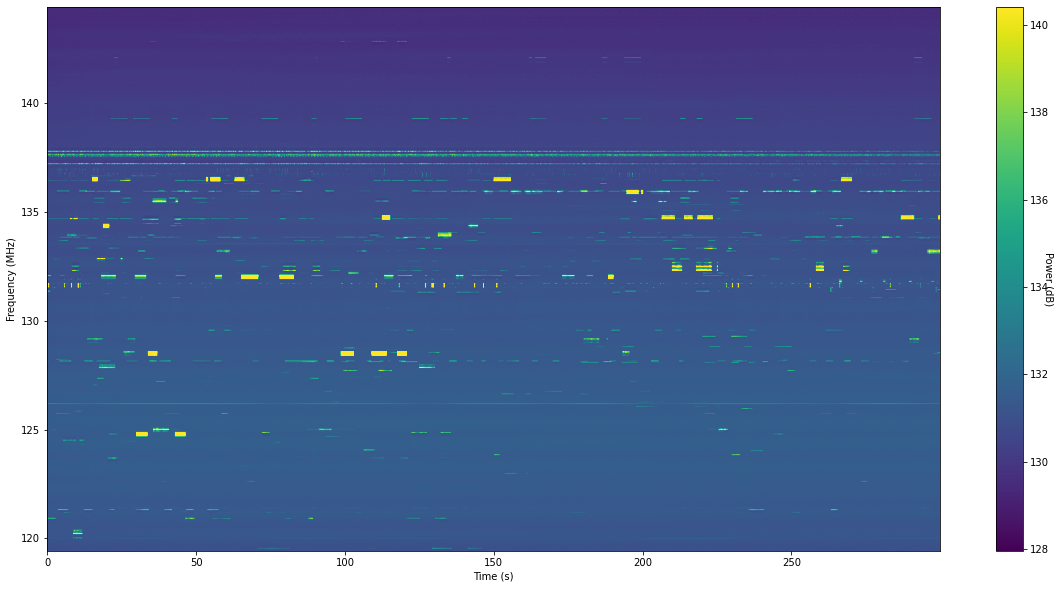

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
img = ax.imshow(data.T, aspect='auto', vmin=vmin, vmax=vmax, origin='lower', extent=[t[0], t[-1], freq[0], freq[-1]])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (MHz)")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Power (dB)", rotation=270)

## Exercise 1
1. What do kind of features do you notice in the filterbank? Can you explain them?
2. Compute the flux in each channel, averaged over the entire observation.
3. Plot this average spectrum.
4. Zoom in on a chunk of a clean part of the spectrum and overplot the subband edges (note that there are 16 channels per subband). What do you notice?

In [17]:
spec = 10.0 * np.log10(np.mean(stokes, axis=0))

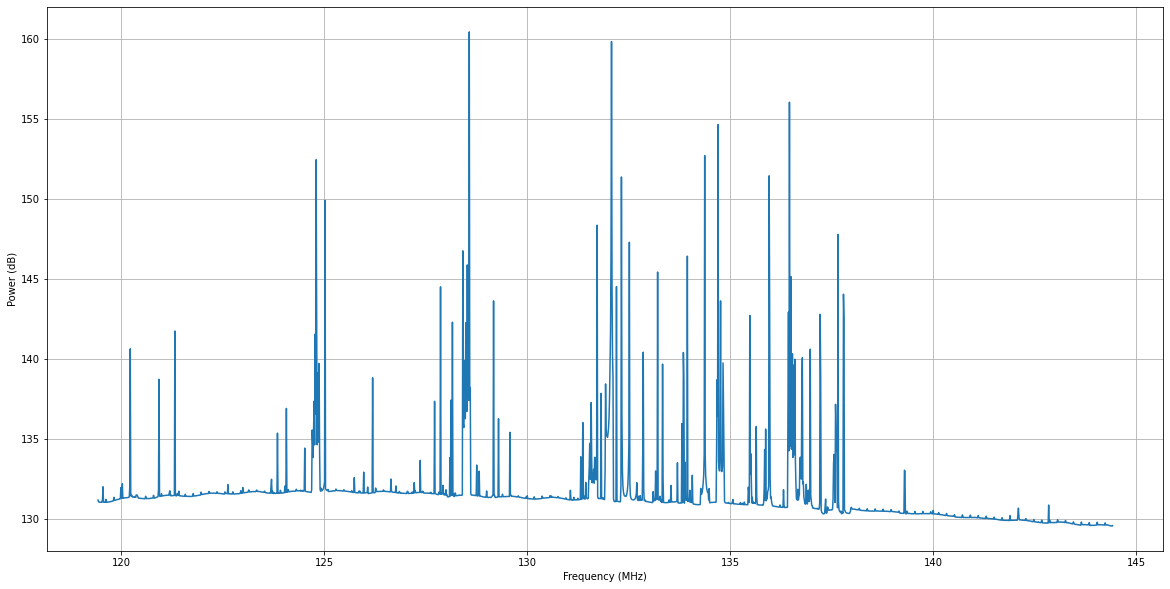

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(freq, spec)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dB)")
ax.grid()

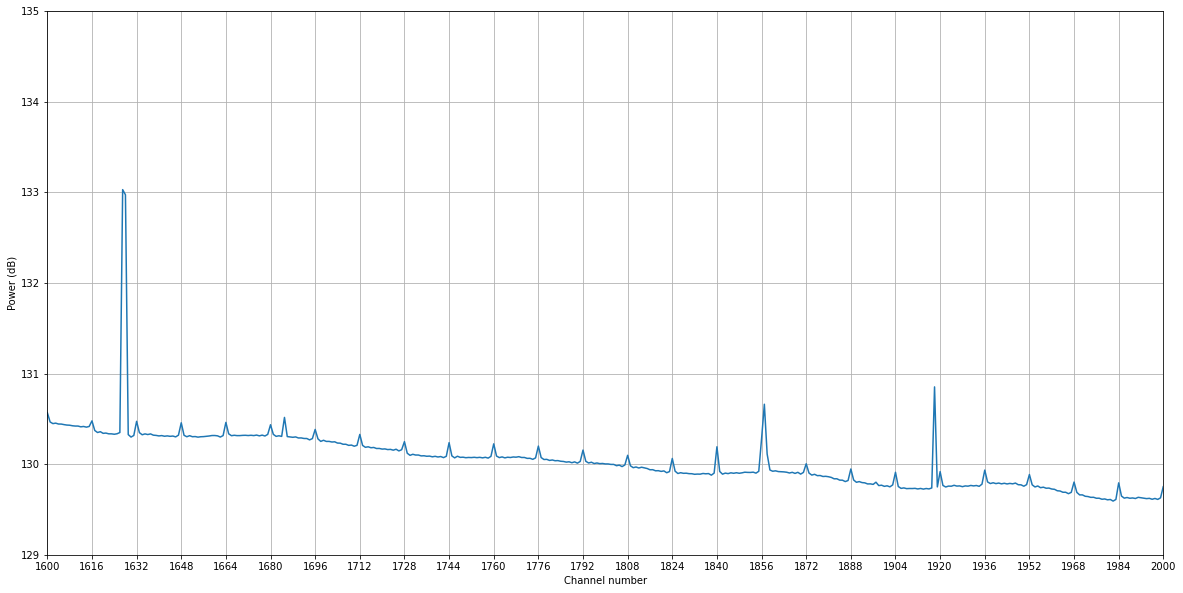

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(spec)
ax.set_xlabel("Channel number")
ax.set_ylabel("Power (dB)")
ax.set_xticks(np.arange(0, 2048, 16))
ax.set_xlim(1600,2000)
ax.set_ylim(129,135)
ax.grid()

## Exercise 2
The dynamic range in the filterbank is dominated by the strong RFI. Let's try to mask the highest values.
1. Use `np.ma.masked_where` to create a masked array where values above some dB limit are masked.
2. Recompute the `vmin` and `vmax` limits, and recreate the filterbank plot.

In [21]:
masked_data = np.ma.masked_where(data > 133.0, data)

In [22]:
vmin = np.median(masked_data) - 2.0 * np.std(masked_data)
vmax = np.median(masked_data) + 6.0 * np.std(masked_data)

/usr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


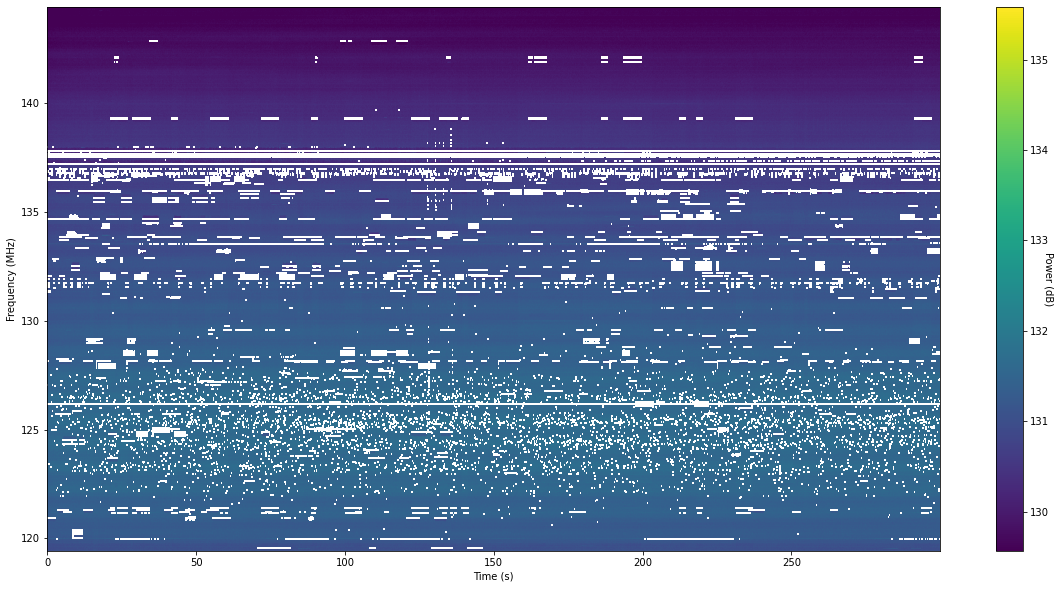

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
img = ax.imshow(masked_data.T, aspect='auto', vmin=vmin, vmax=vmax, origin='lower', extent=[t[0], t[-1], freq[0], freq[-1]])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (MHz)")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Power (dB)", rotation=270)

## Exercise 3
In this observation a bright radio pulsar was observed. Some of its individual pulses are visible between 125 and 135 seconds in the file.
1. Find the time indices of 125 and 135 seconds in the file.
2. Extract a slice of the masked array containing this time range.
3. Plot the filterbank (make sure the axes are correct). Can you see the pulses?

In [26]:
imin = np.abs((t - 125.0)).argmin()
imax = np.abs((t - 135.0)).argmin()
print(imin, imax)

23842 25749


In [27]:
extracted_data = masked_data[imin:imax, :]
extracted_t = t[imin:imax]

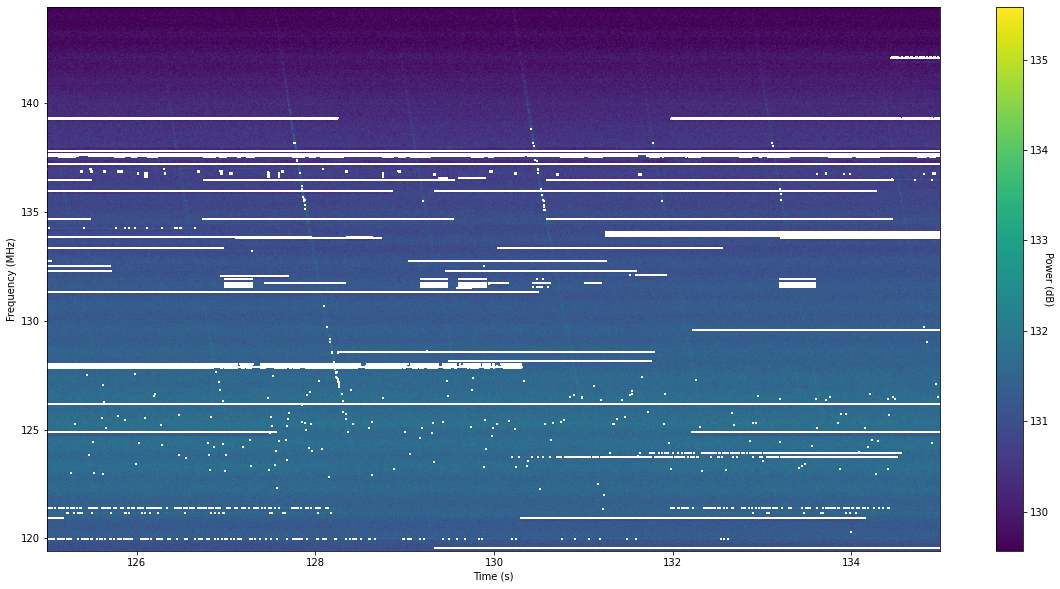

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
img = ax.imshow(extracted_data.T, aspect="auto", vmin=vmin, vmax=vmax, origin="lower", 
                extent=[extracted_t[0], extracted_t[-1], freq[0], freq[-1]])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (MHz)")
cbar= fig.colorbar(img, ax=ax)
cbar.set_label("Power (dB)", rotation=270)

## Exercise 4
The pulsar in this observation is PSR B1919+21, the first pulsar ever to be discovered, which happened in 1967 by Jocelyn Bell Burnell. It has a spin period of 1.3373 s and a dispersion measure of 12.444 pc cm$^{-3}$.
1. For a single pulse, overplot the expected frequency dependence of the pulse, using the fact that the time delay $\Delta t$ (in seconds) between two frequencies $f_0$ and $f_1$ (in MHz) is given by $\Delta t = \mathrm{DM} (f_0^{-2}-f_1^{-2})/2.41\times10^{-4}$ s.
2. Overplot multiple pulses spaced by the spin period of the pulsar to show that the period is correct.

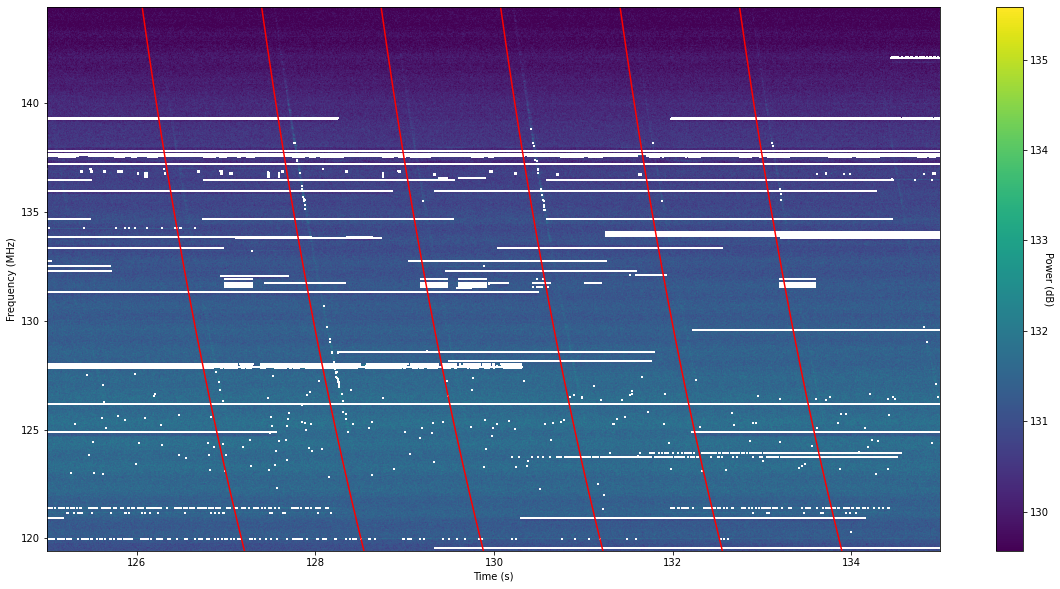

In [30]:
tdm = (freq**(-2) - freq[-1]**(-2)) * 12.444 / 2.41e-4
fig, ax = plt.subplots(figsize=(20, 10))
img = ax.imshow(extracted_data.T, aspect="auto", vmin=vmin, vmax=vmax, origin="lower", 
                extent=[extracted_t[0], extracted_t[-1], freq[0], freq[-1]])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (MHz)")
for pulse in [-1, 0, 1, 2, 3, 4]:
    ax.plot(127.4 + pulse * 1.3373 + tdm, freq, "r")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Power (dB)", rotation=270)